In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer, PowerTransformer, OneHotEncoder, OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

# Načítavanie dát

In [59]:
connections = pd.read_csv('data/081/connections.csv', on_bad_lines='warn', delimiter='\t')
devices = pd.read_csv('data/081/devices.csv', on_bad_lines='warn', delimiter='\t')
processes = pd.read_csv('data/081/processes.csv', on_bad_lines='warn', delimiter='\t')
profiles = pd.read_csv('data/081/profiles.csv', on_bad_lines='warn', delimiter='\t')

# Podiel práce

Tulach 50%

Černega 50%

# Riešenie

## 2.1 A

V tabuľke profiles sa taktiež vyskytoval divný formát latitude a longitude. To sme vyriešili rozdelením atribútu na 2 stĺpce.

In [60]:
def multiple_remove(substrings:list, string:str):
    for substring in substrings:
        string = string.replace(substring, '')
    return string

locations = profiles.current_location
longitude = np.array([], dtype=float)
latitude = np.array([], dtype=float)
for location in locations:
    if(pd.isna(location)):
        longitude = np.append(longitude, np.nan)
        latitude = np.append(latitude, np.nan)
    else:
        lat, lon = location.split(',')
        lat = multiple_remove(['(Decimal(', ')', '\''], lat)
        lon = multiple_remove(['Decimal(', ')', '\''], lon)
        longitude = np.append(longitude, float(lon))
        latitude = np.append(latitude, float(lat))
        
profiles['latitude'] = pd.Series(latitude)
profiles['longitude'] = pd.Series(longitude)
profiles = profiles.drop(labels='current_location', axis=1)

Pozorovali sme, že registrácia v tabuľke devices má nejednotný formát. To sme napokon vyriešili zjednoteným formátom.

In [61]:
# Function to preprocess date strings
def preprocess_date(date_str):
    for fmt in ('%d/%m/%Y, %H:%M:%S', '%d %b %Y', '%Y-%m-%d', '%Y/%m/%d'):
        try:
            return pd.to_datetime(date_str, format=fmt)
        except ValueError:
            continue
    return pd.to_datetime(date_str, errors='coerce')

# Apply the preprocessing function to the 'registration' column
profiles['registration'] = profiles['registration'].apply(preprocess_date)

# Convert the datetime column to a singular string format
profiles['registration'] = profiles['registration'].dt.strftime('%Y-%m-%d')

profiles.registration.head()

0    2019-03-11
1    2023-05-07
2    2019-03-16
3    2018-07-04
4    2022-05-21
Name: registration, dtype: object

Potrebujeme vyriešiť duplikáty v atribútoch imei a user_id. Keďže sú to unikátne identifikátory

In [62]:
profiles = profiles.drop_duplicates(subset=['user_id'])
devices = devices.drop_duplicates(subset=['imei'])

Následne všetky tabuľky spojíme do jednej.

In [63]:
# Merge connections and processes on 'mwra', 'imei', and 'ts'
merged_df = pd.merge(connections, processes, on=['mwra', 'imei', 'ts'])

# Merge the result with devices on 'imei'
merged_df = pd.merge(merged_df, devices, on='imei')

# Merge the result with profiles on 'imei' with custom suffixes
data = pd.merge(merged_df, profiles, on='imei', suffixes=('_devices', '_profile'))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48402 entries, 0 to 48401
Data columns (total 50 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ts                          48402 non-null  object 
 1   imei                        48402 non-null  int64  
 2   mwra                        48402 non-null  float64
 3   c.android.youtube           48402 non-null  float64
 4   c.android.chrome            48402 non-null  float64
 5   c.android.gm                48402 non-null  float64
 6   c.dogalize                  48402 non-null  float64
 7   c.katana                    48402 non-null  float64
 8   c.UCMobile.x86              48402 non-null  float64
 9   c.updateassist              48402 non-null  float64
 10  c.android.vending           48402 non-null  float64
 11  c.UCMobile.intl             48402 non-null  float64
 12  c.raider                    48402 non-null  float64
 13  p.android.packageinstaller  484

Moje zdôvodnenie pre tento krok je ten, že sme v prvej fáze niektoré stĺpce niektorých tabuliek mazali a prerábali na dva osobitné stĺpce (konkrétne stĺpec location sme úplne zmazali a tie dáta sme prerobili na latitude a longtitude, keďže je lepšie mať univerzálny formát dát). Sekvenčne je vytvorenie testovacej a trénovacej sady z týchto dát ako prvá úloha v tejto fáze zadania, a síce už máme odstránených outlierov, mohli nám vzniknúť nové, ktoré by sme dokázali odstrániť pomocou Pipeline tak či tak. Vytvoríme si teda testovaciu a trénovaciu sadu:

In [64]:
# Define the target variable and features
X = data.drop(columns=['mwra'])
y = data['mwra']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the resulting datasets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (38721, 49)
X_test shape: (9681, 49)
y_train shape: (38721,)
y_test shape: (9681,)


Ďalej budeme už robiť zatiaľ s trénovacím datasetom.

## 2.1 B

### Imputing

Najprv vytvoríme nový dataframe, kde odstránime riadky s nedefinovanými hodnotami z nášho daného datasetu:

In [65]:
# Remove NA values from the training dataset
X_train_cleaned = X_train.dropna()
y_train_cleaned = y_train[X_train_cleaned.index]

# Print the number of rows in the cleaned training dataset
print(f"Number of rows in the cleaned training dataset: {X_train_cleaned.shape[0]}")

Number of rows in the cleaned training dataset: 6148


Vidíme, že z pôvodných 38721 hodnôt sa nám počet zredukoval na 6148, preto je to celkom nešťastné riešenie a bolo by lepšie, keby sme chýbajúce hodnoty nejakou štatistickou metódou do nášho datasetu doplnili.

Ako prvé však zistíme, či nie je missing values príliš veľa, ako sme to robili vo fáze 1. Ak áno, tak stĺpec zmažeme

In [66]:
for label, column in X_train.items():
    ratio = len(column.dropna()) / len(column)
    #imputation threshhold should be 80%
    if(ratio < 0.8):
       print(f"Dropped: {label}")
       X_train = X_train.drop(label, axis=1)

Dropped: birthdate
Dropped: job


Tu teda doplníme hodnoty tak, že pre každý atribút sa zoberie priemerná hodnota, resp. najčastejšia hodnota pre kategorické atribúty a doplní sa do jednotlivých atribútov pomocou triedy SimpleImputer:

In [67]:
# Identify numerical and categorical columns
numerical_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

# Create imputers
imputer_num = SimpleImputer(strategy='mean')
imputer_cat = SimpleImputer(strategy='most_frequent')

# Fit and transform the data
X_train[numerical_cols] = imputer_num.fit_transform(X_train[numerical_cols])
X_train[categorical_cols] = imputer_cat.fit_transform(X_train[categorical_cols])

# Check if every column has the same amount of non-null values
non_null_counts = X_train.notnull().sum()
print(non_null_counts)
all_equal = non_null_counts.nunique() == 1
print(f"All columns have the same amount of non-null values: {all_equal}")

ts                            38721
imei                          38721
c.android.youtube             38721
c.android.chrome              38721
c.android.gm                  38721
c.dogalize                    38721
c.katana                      38721
c.UCMobile.x86                38721
c.updateassist                38721
c.android.vending             38721
c.UCMobile.intl               38721
c.raider                      38721
p.android.packageinstaller    38721
p.android.documentsui         38721
p.system                      38721
p.android.externalstorage     38721
p.android.chrome              38721
p.android.settings            38721
p.android.gm                  38721
p.inputmethod.latin           38721
p.android.vending             38721
p.process.gapps               38721
p.notifier                    38721
p.katana                      38721
p.google                      38721
p.android.defcontainer        38721
p.simulator                   38721
p.android.gms               

Vidíme, že každý stĺpec má rovnaký počet hodnôt, ktoré sú nenulové, to znamená, že sa úspešne nahradili nulové hodnoty v datasete.

### Encoding

In [68]:
X_train[categorical_cols]

,ts,store_name,code,location,name,ssn,company,address,username,registration,mail
10171,2018-05-07 15:38:00,Ehingen,DE,Europe/Berlin,Tracy Taylor,509-75-4348,Owens LLC,"7331 Robert Hill Suite 097\nMatthewmouth, UT 7...",stuartcarolyn,2023-10-15,evasquez@hotmail.com
13377,2018-05-08 08:26:00,Stade,DE,Europe/Berlin,Tiffany Heath,532-61-7993,Stanton Group,USNS Campbell\nFPO AE 93504,steven62,2020-07-24,randallandrea@gmail.com
4593,2018-05-06 10:02:00,Kendall,US,America/New_York,Robert Hall,178-61-9896,"Reeves, Allen and Gordon","679 Cordova Vista\nSouth Dakotaview, GA 24986",jwilson,2024-05-21,dustin56@gmail.com
46288,2018-05-15 14:32:00,Recife,BR,America/Recife,Amy Rojas,579-15-0177,"Cruz, Alvarado and Price","341 Ashley Light\nClarkestad, KY 28434",moorealexandria,2019-06-25,ctaylor@hotmail.com
45969,2018-05-15 12:51:00,Baulkham Hills,AU,Australia/Sydney,Mr. Stephen Ramirez,346-63-2554,Brown Ltd,Unit 6590 Box 7989\nDPO AP 35721,jennifer80,2021-10-06,michellearnold@yahoo.com
...,...,...,...,...,...,...,...,...,...,...,...
11284,2018-05-07 21:40:00,Mount Hagen,PG,Pacific/Port_Moresby,James Garcia MD,693-24-1581,Hernandez-Molina,6166 Rachel Pass Suite 361\nNorth Matthewmouth...,brandibutler,2024-07-24,johnmiller@yahoo.com
44732,2018-05-15 06:09:00,Diamond Harbour,IN,Asia/Kolkata,Kristy Miller,224-99-2485,"Roberts, Hill and Hardy","487 Graham Turnpike Suite 340\nWest Tonyafort,...",kcross,2022-09-19,cameron09@gmail.com
38158,2018-05-13 19:49:00,Walton-on-the-Naze,GB,Europe/London,Eric Walton,062-25-6436,"Williams, Walker and Wiggins","4153 Daniels Valleys\nWest Danielburgh, CO 19331",landryamy,2022-08-30,qjones@yahoo.com
860,2018-05-05 14:26:00,Likhobory,RU,Europe/Moscow,Eddie Clark Jr.,779-69-7513,Powers-Lopez,"98893 Shannon Pines\nNew Justinstad, MD 01457",barrydarlene,2018-10-10,rsharp@hotmail.com


Tu môžeme vidieť stĺpce, ktoré obsahujú kategorické hodnoty, ktoré môžeme transformovať na numerické dáta na trénovanie modelu, avšak niektoré dáta ako ssn (social security number) alebo username môžu byť unikátne, tak by nemali veľkú výpovednú hodnotu pre trénovanie modelu. Atribúty, čo budú mať určite väčšiu výpovednú hodnotu sú job a location. Môžeme použiť ordinal encoding na všetky tieto stĺpce:

In [69]:
from sklearn.preprocessing import OrdinalEncoder

# Initialize the OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

# Fit and transform the categorical columns
X_train[categorical_cols] = ordinal_encoder.fit_transform(X_train[categorical_cols])

# Display the first few rows of the transformed dataframe
print(X_train.head())

            ts          imei  c.android.youtube  c.android.chrome  \
10171   2965.0  3.590434e+18           12.81880           8.97081   
13377   3889.0  8.630331e+17           19.28031          13.40403   
4593    1316.0  8.630331e+17           12.15513          11.93005   
46288  13422.0  3.590434e+17           17.65376          10.82544   
45969  13327.0  8.630331e+17           15.38594          14.67761   

       c.android.gm  c.dogalize  c.katana  c.UCMobile.x86  c.updateassist  \
10171      14.47037    14.21689   9.45267        66.95868        88.04664   
13377      14.80080    10.63325  13.36446        47.76608        68.44588   
4593       12.09731    15.65868  11.94995        31.61047        55.68409   
46288       9.77500    12.53725  14.10987        29.99086        51.89900   
45969      13.70817    17.03071  12.56947        34.58443        60.88031   

       c.android.vending  ...    name     ssn  company  user_id  address  \
10171           66.14673  ...  1490.0   897.0 

Teraz skontrolujeme, či sa nám pri mergnuti nevytvorili duplikáty. To by bolo neprijatelné, keďže to by mohlo viesť k overfittingu modelu.

In [70]:
print(X_train.duplicated().value_counts())
X_train.drop_duplicates()

False    37458
True      1263
Name: count, dtype: int64


,ts,imei,c.android.youtube,c.android.chrome,c.android.gm,c.dogalize,c.katana,c.UCMobile.x86,c.updateassist,c.android.vending,...,name,ssn,company,user_id,address,username,registration,mail,latitude_profile,longitude_profile
10171,2965.0,3.590434e+18,12.81880,8.97081,14.47037,14.21689,9.45267,66.95868,88.04664,66.14673,...,1490.0,897.0,981.0,851.0,863.0,1345.0,997.0,398.0,68.537374,-103.271184
13377,3889.0,8.630331e+17,19.28031,13.40403,14.80080,10.63325,13.36446,47.76608,68.44588,56.64237,...,1444.0,930.0,1261.0,491.0,1263.0,1334.0,458.0,1150.0,-24.678717,110.294407
4593,1316.0,8.630331e+17,12.15513,11.93005,12.09731,15.65868,11.94995,31.61047,55.68409,50.51668,...,1244.0,323.0,1085.0,2391.0,802.0,723.0,1101.0,354.0,1.289970,133.526894
46288,13422.0,3.590434e+17,17.65376,10.82544,9.77500,12.53725,14.10987,29.99086,51.89900,27.43302,...,48.0,1011.0,285.0,2181.0,426.0,992.0,283.0,265.0,-76.195598,168.240245
45969,13327.0,8.630331e+17,15.38594,14.67761,13.70817,17.03071,12.56947,34.58443,60.88031,46.28680,...,1102.0,624.0,136.0,1804.0,1328.0,629.0,660.0,965.0,-22.822284,-151.353799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,3299.0,3.590434e+17,11.19570,13.04801,15.03613,11.11381,8.71783,77.48363,39.40527,26.20681,...,572.0,1209.0,562.0,78.0,741.0,132.0,1124.0,674.0,-19.415305,-130.330234
44732,12952.0,8.630331e+18,13.58486,16.67089,10.84218,10.05975,9.25725,51.57434,33.63553,70.18344,...,887.0,408.0,1115.0,2020.0,598.0,740.0,830.0,167.0,-34.911698,106.241706
38158,11080.0,3.590434e+18,13.56710,14.34251,10.41026,15.36798,11.36921,30.07654,61.94649,94.61778,...,471.0,103.0,1453.0,1229.0,517.0,798.0,820.0,1133.0,57.720516,-134.864877
860,242.0,3.590434e+18,12.04454,14.49804,11.92325,12.79680,14.95542,82.38211,64.24523,69.75112,...,435.0,1362.0,1062.0,1962.0,1193.0,103.0,167.0,1221.0,-57.736437,-92.712062


Týmto sme zabezpečili unikátnosť pozorovaní.

C:\Users\nayhu\AppData\Local\Temp\ipykernel_96668\1014822780.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  X_train.hist(ax=ax)


array([[<Axes: title={'center': 'ts'}>, <Axes: title={'center': 'imei'}>,
        <Axes: title={'center': 'c.android.youtube'}>,
        <Axes: title={'center': 'c.android.chrome'}>,
        <Axes: title={'center': 'c.android.gm'}>,
        <Axes: title={'center': 'c.dogalize'}>,
        <Axes: title={'center': 'c.katana'}>],
       [<Axes: title={'center': 'c.UCMobile.x86'}>,
        <Axes: title={'center': 'c.updateassist'}>,
        <Axes: title={'center': 'c.android.vending'}>,
        <Axes: title={'center': 'c.UCMobile.intl'}>,
        <Axes: title={'center': 'c.raider'}>,
        <Axes: title={'center': 'p.android.packageinstaller'}>,
        <Axes: title={'center': 'p.android.documentsui'}>],
       [<Axes: title={'center': 'p.system'}>,
        <Axes: title={'center': 'p.android.externalstorage'}>,
        <Axes: title={'center': 'p.android.chrome'}>,
        <Axes: title={'center': 'p.android.settings'}>,
        <Axes: title={'center': 'p.android.gm'}>,
        <Axes: title=

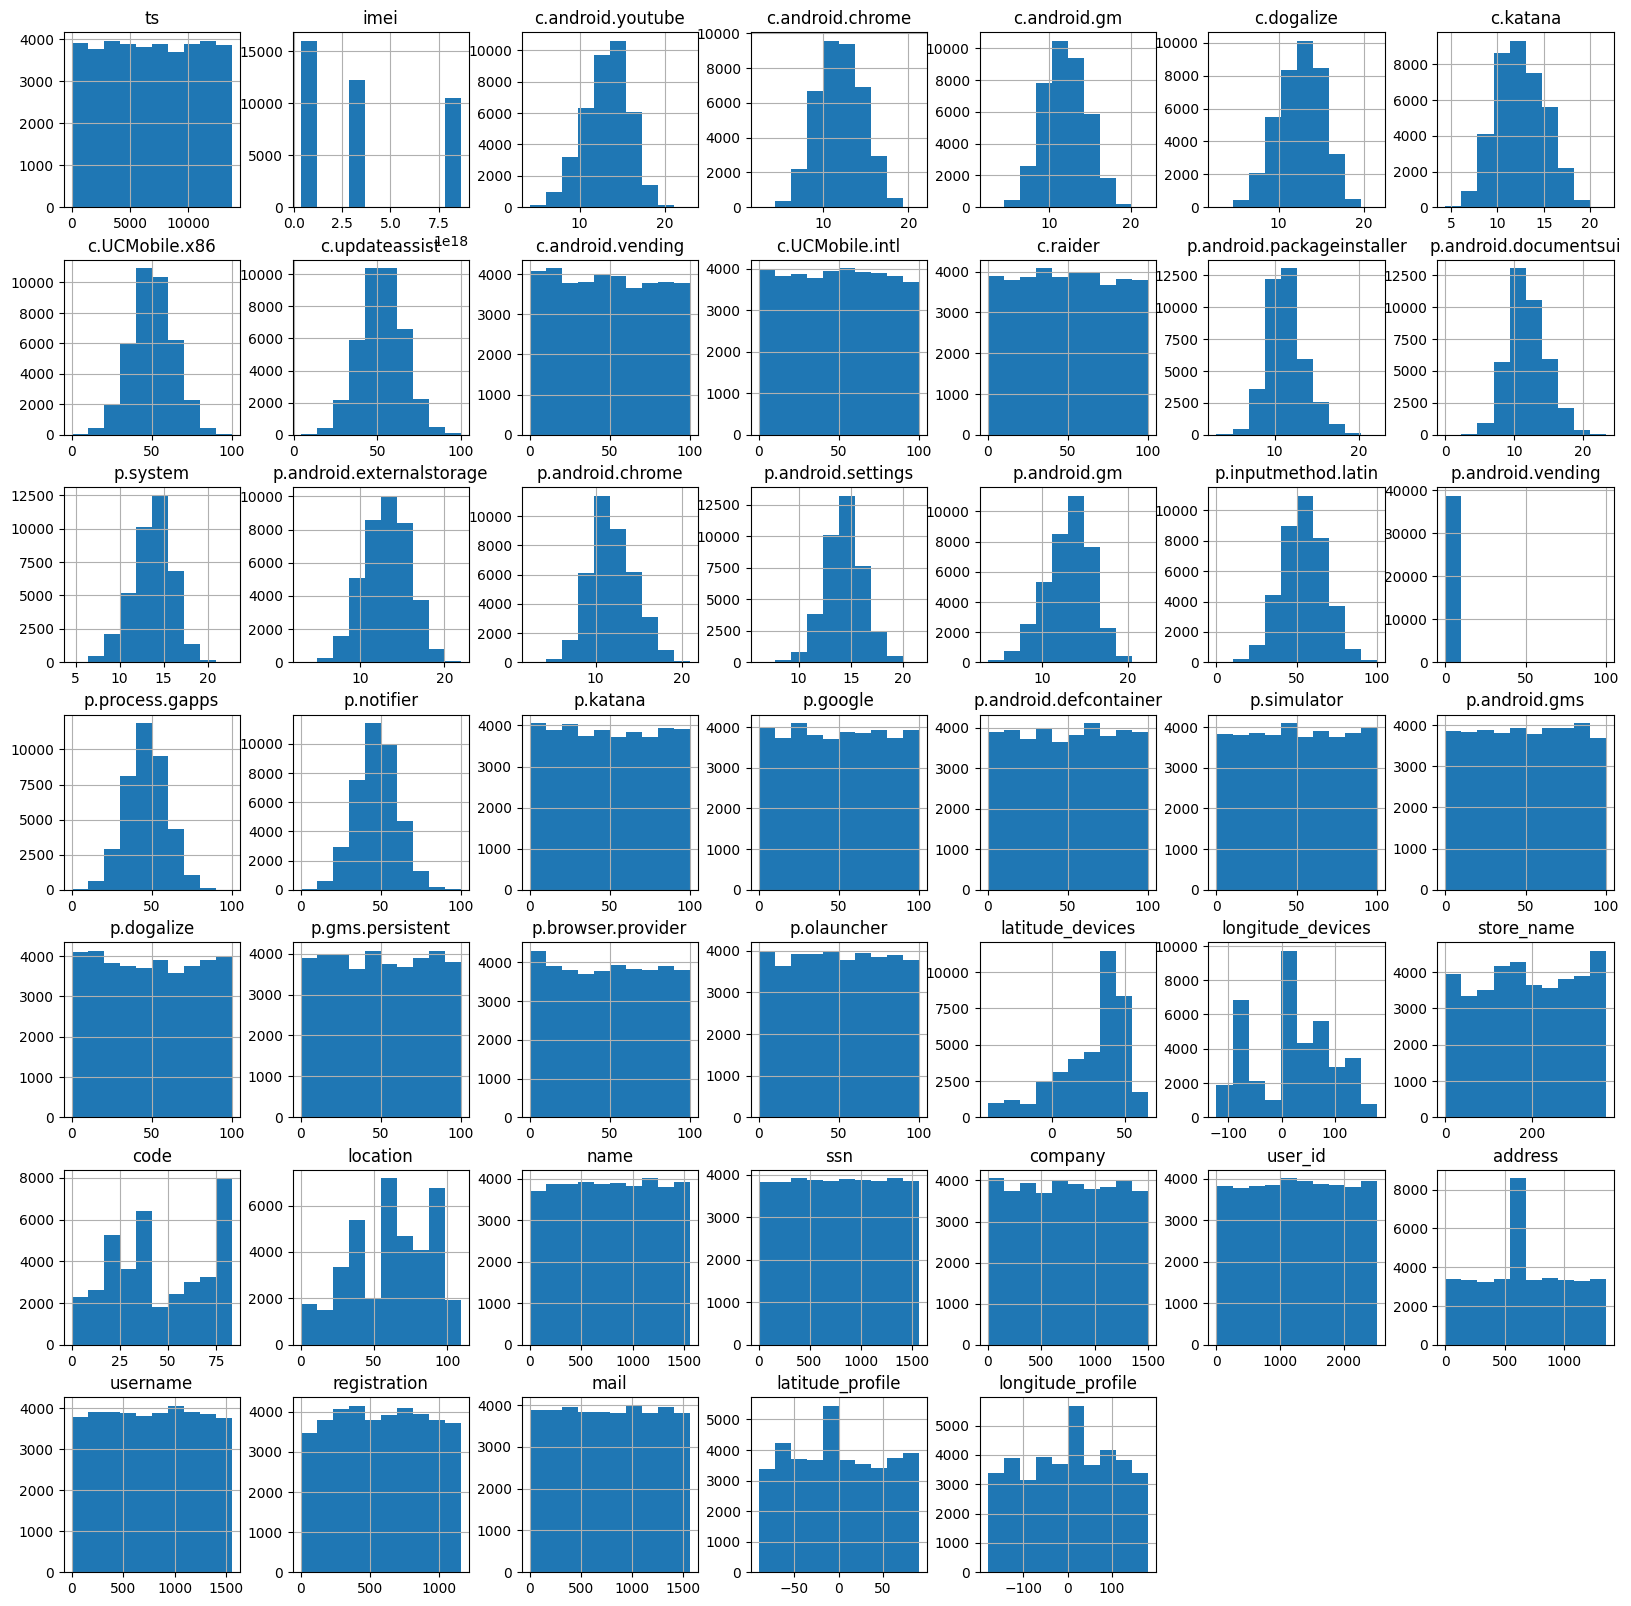

In [71]:
fig = plt.figure(figsize = (20,20))
ax = fig.gca()
X_train.hist(ax=ax)

Následne potrebujeme vyriešiť problém s vychýlenými hodnotami.

Použijeme metódu odstránenia podľa IQR.

In [72]:
def delete_outliers(dataframe, col):
    Q3 = dataframe[col].quantile(0.75)
    Q1 = dataframe[col].quantile(0.25)
    IQR = Q3 - Q1
    return dataframe.loc[(dataframe[col] <= Q1 - 1.5*IQR) | (dataframe[col] >= Q3 + 1.5*IQR), col].index

deleted_sum = 0
for column in X_train.columns:
    indexes = list(delete_outliers(X_train, column))
    for item in indexes:
        deleted_sum +=1
        X_train = X_train.drop(item)
        y_train = y_train.drop(item)
print(deleted_sum)

10738


C:\Users\nayhu\AppData\Local\Temp\ipykernel_96668\1014822780.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  X_train.hist(ax=ax)


array([[<Axes: title={'center': 'ts'}>, <Axes: title={'center': 'imei'}>,
        <Axes: title={'center': 'c.android.youtube'}>,
        <Axes: title={'center': 'c.android.chrome'}>,
        <Axes: title={'center': 'c.android.gm'}>,
        <Axes: title={'center': 'c.dogalize'}>,
        <Axes: title={'center': 'c.katana'}>],
       [<Axes: title={'center': 'c.UCMobile.x86'}>,
        <Axes: title={'center': 'c.updateassist'}>,
        <Axes: title={'center': 'c.android.vending'}>,
        <Axes: title={'center': 'c.UCMobile.intl'}>,
        <Axes: title={'center': 'c.raider'}>,
        <Axes: title={'center': 'p.android.packageinstaller'}>,
        <Axes: title={'center': 'p.android.documentsui'}>],
       [<Axes: title={'center': 'p.system'}>,
        <Axes: title={'center': 'p.android.externalstorage'}>,
        <Axes: title={'center': 'p.android.chrome'}>,
        <Axes: title={'center': 'p.android.settings'}>,
        <Axes: title={'center': 'p.android.gm'}>,
        <Axes: title=

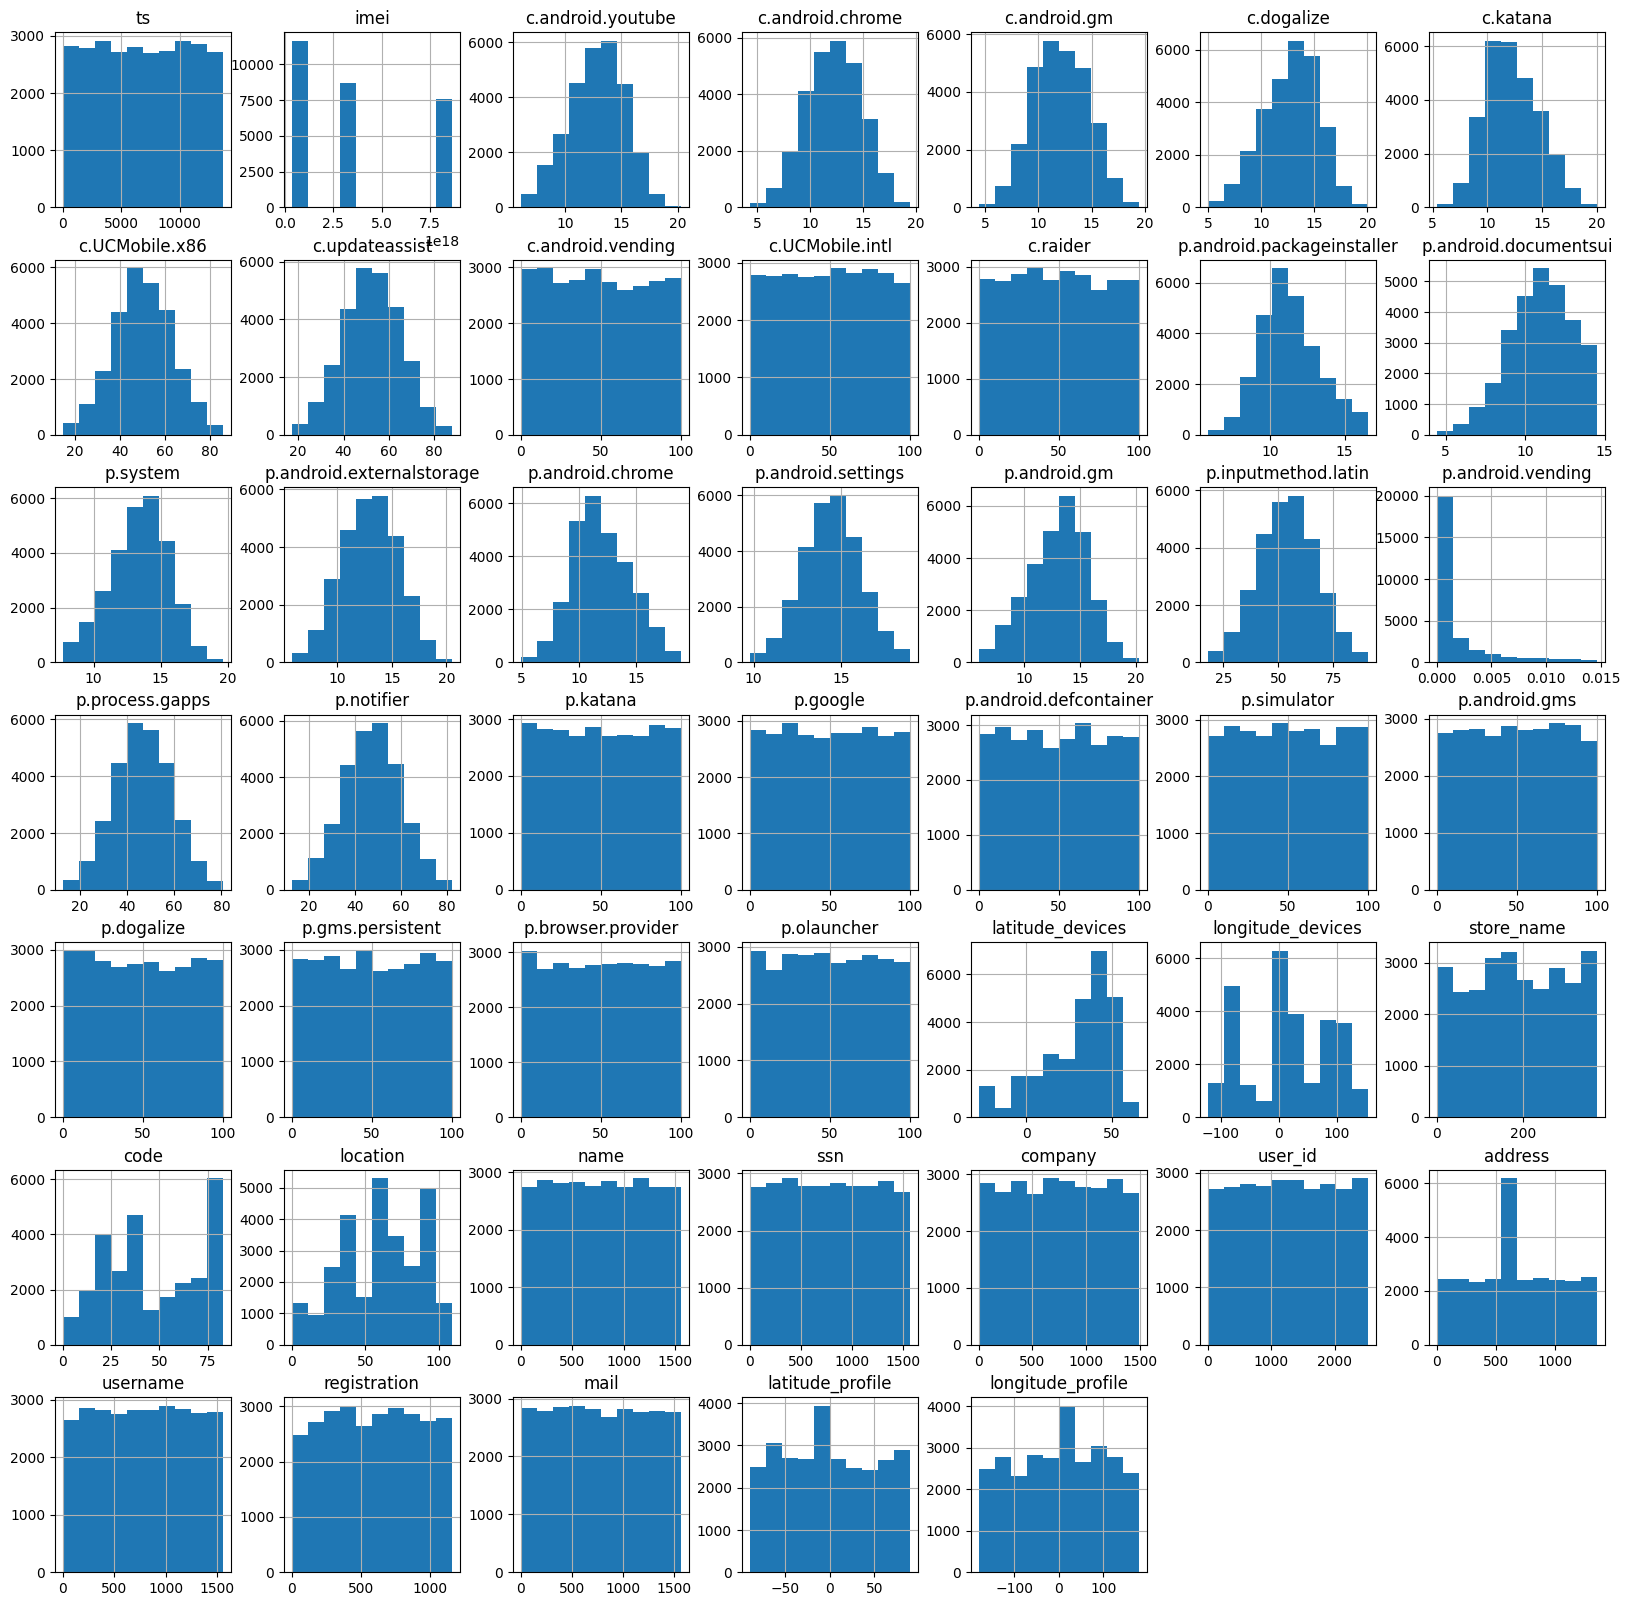

In [73]:
fig = plt.figure(figsize = (20,20))
ax = fig.gca()
X_train.hist(ax=ax)

Týmto sme odstránili všetky outliery, ktoré sa v dátach nachádzali.

## 2.1 C

V tomto kroku najprv sekvenčne transformujeme dáta tak, že najprv použijeme scaling a potom transformers, z každej časti 2 techniky.

Rozdelíme si atribúty vzhľadom na to, či ich dáta podliehajú normálnej distribúcii alebo nie. Podľa toho sa rozhodneme, či použijeme na daný atribút StandardScaler alebo MinMaxScaler:

In [74]:
def is_normal_distribution(X_train, alpha=0.05):
    stat, p = stats.kstest(X_train, 'norm', args=(np.mean(X_train), np.std(X_train)))
    return p > alpha

normal_cols, non_normal_cols = [], []

for column in X_train.columns:
    if is_normal_distribution(X_train[column]):
        normal_cols.append(column)
    else:
        non_normal_cols.append(column)

normal_scaling = StandardScaler()
non_normal_scaling = MinMaxScaler()

scalers = [
    ('normal', normal_scaling, normal_cols),
    ('non_normal', non_normal_scaling, non_normal_cols)
]

column_transformer = ColumnTransformer(scalers)

# Fit and transform the data with scaling
X_train = column_transformer.fit_transform(X_train)

# Convert the transformed data back to a DataFrame
X_train = pd.DataFrame(X_train, columns=normal_cols + non_normal_cols)

# Display the transformed data
print(X_train.head())

   p.android.settings  p.notifier        ts          imei  c.android.youtube  \
0           -1.226577   -1.108476  0.096044  6.093244e-02           0.427370   
1            0.547378   -1.836996  0.979565  6.245005e-17           0.813759   
2            0.562819    0.587252  0.343235  6.093244e-02           0.242059   
3           -1.629362    1.497645  0.673989  6.093244e-02           0.632050   
4           -0.348991   -0.505866  0.121150  1.000000e+00           0.644875   

   c.android.chrome  c.android.gm  c.dogalize  c.katana  c.UCMobile.x86  ...  \
0          0.503538      0.511196    0.708777  0.448911        0.238916  ...   
1          0.430316      0.356433    0.501798  0.596285        0.216143  ...   
2          0.586763      0.292796    0.569548  0.354157        0.418987  ...   
3          0.599183      0.523448    0.370054  0.510090        0.531156  ...   
4          0.625694      0.644037    0.462990  0.332379        0.609035  ...   

       name       ssn   company   user

Vidíme, že dáta sú dobre naškálované, následne teda použijeme transformácie PowerTransformer a QuantileTransformer tiež v závislosti od toho, či sú dáta daných atribútov distribuované normálne alebo nie:

In [75]:
# PowerTransformer for normally distributed columns
power_transformer = PowerTransformer()

# QuantileTransformer for non-normally distributed columns
quantile_transformer = QuantileTransformer(output_distribution='normal')

transformers = [
    ('power', power_transformer, normal_cols),  # Apply PowerTransformer to normally distributed columns
    ('quantile', quantile_transformer, non_normal_cols)  # Apply QuantileTransformer to non-normally distributed columns
]

# Create the ColumnTransformer
column_transformer = ColumnTransformer(transformers)

# Fit and transform the data with scaling and encoding
X_train = column_transformer.fit_transform(X_train)

# Convert the transformed data back to a DataFrame
X_train = pd.DataFrame(X_train, columns=normal_cols + non_normal_cols)

# Display the transformed data
print(X_train.head())

   p.android.settings  p.notifier        ts      imei  c.android.youtube  \
0           -1.225610   -1.107871 -1.302745 -0.257495          -0.331013   
1            0.546302   -1.832758  2.039634 -5.199338           2.153600   
2            0.561776    0.586103 -0.398923 -0.257495          -1.233439   
3           -1.626685    1.500072  0.430566 -0.257495           0.872653   
4           -0.350426   -0.507218 -1.169429  5.199338           0.964413   

   c.android.chrome  c.android.gm  c.dogalize  c.katana  c.UCMobile.x86  ...  \
0         -0.127520      0.032647    1.130769 -0.028859       -1.412919  ...   
1         -0.498431     -0.833781   -0.165072  0.712407       -1.515677  ...   
2          0.314776     -1.268483    0.231840 -0.628244       -0.428868  ...   
3          0.380806      0.100654   -0.796745  0.293286        0.177684  ...   
4          0.527797      0.706371   -0.360369 -0.773626        0.599269  ...   

       name       ssn   company   user_id   address  username 

Pozrieme sa na histogramy grafov potom, ako sme použili transformácie:

C:\Users\nayhu\AppData\Local\Temp\ipykernel_96668\1014822780.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  X_train.hist(ax=ax)


array([[<Axes: title={'center': 'p.android.settings'}>,
        <Axes: title={'center': 'p.notifier'}>,
        <Axes: title={'center': 'ts'}>, <Axes: title={'center': 'imei'}>,
        <Axes: title={'center': 'c.android.youtube'}>,
        <Axes: title={'center': 'c.android.chrome'}>,
        <Axes: title={'center': 'c.android.gm'}>],
       [<Axes: title={'center': 'c.dogalize'}>,
        <Axes: title={'center': 'c.katana'}>,
        <Axes: title={'center': 'c.UCMobile.x86'}>,
        <Axes: title={'center': 'c.updateassist'}>,
        <Axes: title={'center': 'c.android.vending'}>,
        <Axes: title={'center': 'c.UCMobile.intl'}>,
        <Axes: title={'center': 'c.raider'}>],
       [<Axes: title={'center': 'p.android.packageinstaller'}>,
        <Axes: title={'center': 'p.android.documentsui'}>,
        <Axes: title={'center': 'p.system'}>,
        <Axes: title={'center': 'p.android.externalstorage'}>,
        <Axes: title={'center': 'p.android.chrome'}>,
        <Axes: title={'

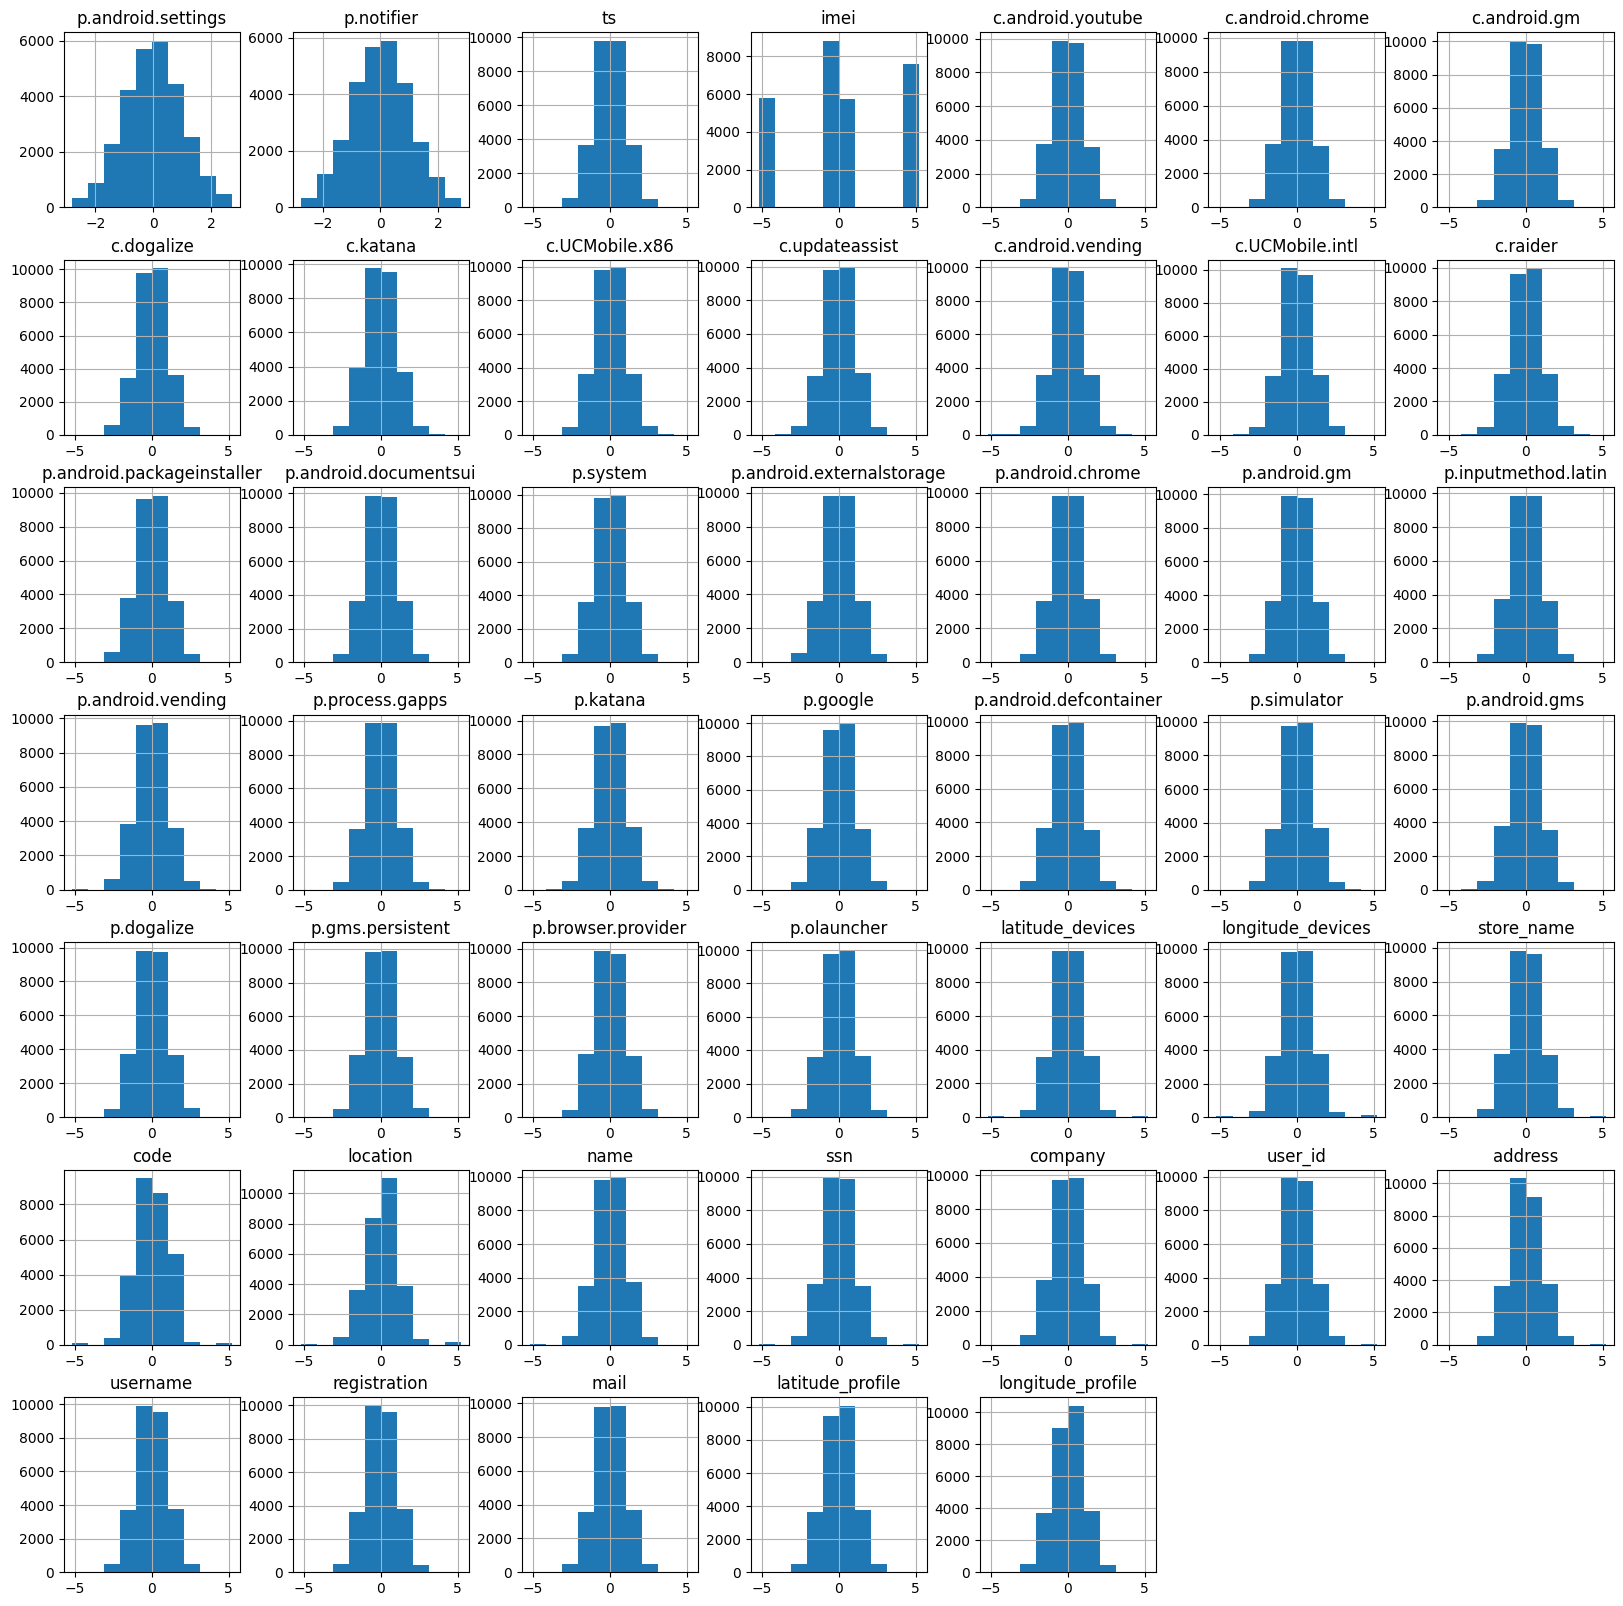

In [76]:
fig = plt.figure(figsize = (20,20))
ax = fig.gca()
X_train.hist(ax=ax)

Môžeme vidieť, že sme dané atribúty úspešne pretransformovali.

## 2.1 D

Všetky predošlé kroky boli priebežne zdôvodňované a dokumentované vo formáte Markdown.

# 2.2

## 2.2 A

V tejto časti vyberieme features, ktoré sú informatívne k predikovanej premennej mwra. Na to musíme použiť menimálne 3 techniky a porovnať výsledky medzi sebou.

Ako prvú techniku použijeme Mutual information.
A skúsime vybrať 5 najlepších atribútov.

Najskôr však potrebuejem rozlíšiť, ktoré features sú kategorické a ktoré spojité. Keďže budeme používať 2 rôzne funkcie, kde 1 funguje s jednými dátami a druhá s druhými.

In [81]:
def mic(X, y):   
    selector = mutual_info_classif(X, y)
    scores = pd.Series(selector, index=X.columns).sort_values()

    plt.figure(figsize=(10,2))
    scores.plot(kind='barh')
    print(scores.sort_values(ascending=False))

store_name      0.011037
location        0.009787
address         0.006235
registration    0.005335
code            0.005088
user_id         0.004978
company         0.004590
imei            0.002325
mail            0.001217
username        0.000684
ssn             0.000407
name            0.000000
dtype: float64


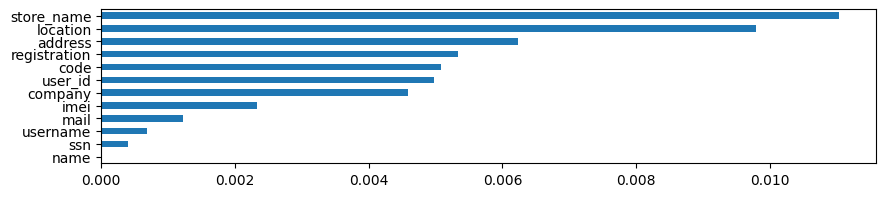

In [85]:
discrete_columns = ['store_name', 'code',
       'location', 'name', 'ssn', 'company', 'user_id', 'address', 'username',
       'registration', 'mail', 'imei']

mic(X_train[discrete_columns], y_train)

Vidíme, že pre diskrétne atribúty je mutual information nízka, až neexistujúca. Tieto atribúty nám vôbec nepomôžu podľa tejto metódy.

Teraz zistíme Mutual information pre spojité atribúty.

In [95]:
def mir(X, y, k=4):
    
    selector = SelectKBest(score_func=mutual_info_regression, k=int(k))
    selector.fit_transform(X, y)
   
    scores = pd.Series(abs(selector.scores_), index=X.columns).sort_values()
    print(scores.sort_values(ascending=False))
    

In [112]:
mir(X_train, y_train, 5)

c.android.gm                  0.472938
c.android.chrome              0.461156
p.android.externalstorage     0.452828
p.android.chrome              0.427361
p.android.gm                  0.422689
c.android.youtube             0.417427
p.system                      0.412013
p.android.packageinstaller    0.406098
p.android.documentsui         0.397048
c.dogalize                    0.392856
p.notifier                    0.391853
p.katana                      0.391821
p.android.settings            0.390682
p.google                      0.389684
p.browser.provider            0.385750
p.dogalize                    0.385120
c.updateassist                0.384605
c.android.vending             0.384472
c.UCMobile.x86                0.384415
ts                            0.383812
p.android.gms                 0.383744
p.olauncher                   0.383182
p.simulator                   0.382053
c.katana                      0.380692
c.raider                      0.379945
p.process.gapps          

Tento test nám ukázal, že najlepšie atribúty na určenie mwra sú c.android.gm, c.android.chrome a c.android.externalstorage . Vidíme však, že ani ďalšie atribúty nie sú na zahodenie. Preto použijeme ďalší spôsob výberu atribútov.

List najlepších atribútov podľa MI:
1. c.android.gm                  (0.469170)
2. c.android.chrome              (0.458254)
3. p.android.externalstorage     (0.453482)
4. p.android.chrome              (0.424711)
5. p.android.gm                  (0.421268)

Keďže pre Chi-squared test potrebujeme len pozitívne hodnoty, tak musíme použiť iný test.

Ďalší spôsob, ktorý použijeme bude ANOVA.

In [ ]:
selector = SelectKBest(score_func=f_regression, k=5)
selector.fit_transform(X_train, y_train)
scores = pd.Series(abs(selector.scores_), index=X_train.columns).sort_values()

print(scores.sort_values(ascending=False))

c.android.gm                  12732.871488
c.android.chrome              11261.641209
p.android.externalstorage     10515.373295
c.android.youtube              4857.601085
p.android.chrome               3461.061886
p.android.gm                   3081.951842
p.android.packageinstaller     2597.209840
p.system                       2126.928771
p.android.vending               608.966661
p.android.documentsui           591.234708
c.katana                        431.231663
c.dogalize                       78.506576
c.updateassist                   29.274192
code                             23.381505
p.google                         15.152648
store_name                       13.098108
p.android.settings               11.877851
imei                             10.916464
p.android.gms                    10.086238
p.olauncher                       8.236961
ts                                7.948170
p.gms.persistent                  7.129396
p.katana                          6.057901
c.android.v

ANOVA nám hovorí, že najlepšie atribúty sú tieto:

1. c.android.gm                  (12732.871488)
2. c.android.chrome              (11261.641209)
3. p.android.externalstorage     (10515.373295)
4. c.android.youtube             (4857.601085)
5. p.android.chrome              (3461.061886)

Na rozdiel od prvého Mutual information výberu, v tomto liste chýba **p.android.gm** a namiesto toho tu je **c.android.youtube**.


Vidíme však, že p.andoird.gm sa umiestnil na šiestom mieste v ANOVA liste a zas c.android.youtube sa umiesntil na 6. mieste v Mutual information liste.

To nám dokazuje, že oba atribúty sú dobre informatívne voči mwra, ale ak by sme si mali vybrať jeden z nich, tak by to bol **c.android.youtube**, keďže v ANOVA teste obstál o dosť lepšie a v Mutual information ten výsledok nebol až tak rozdielny.

Ako tretí spôsob použijeme SelectFromModel s modelom Logistic regression.

In [127]:
selector = SelectFromModel(estimator=LogisticRegression(), max_features=10)
selector.fit_transform(X_train, y_train)
scores = pd.Series(abs(selector.estimator_.coef_[0]), index=X_train.columns).sort_values()

print(scores.sort_values(ascending=False))

c.android.gm                  1.154576
p.android.externalstorage     0.839169
c.android.chrome              0.828720
c.dogalize                    0.629190
p.android.packageinstaller    0.435094
p.android.chrome              0.428320
c.katana                      0.316105
p.android.settings            0.234312
p.android.gm                  0.207345
p.android.vending             0.200697
p.android.documentsui         0.169236
p.system                      0.146190
c.updateassist                0.080563
p.simulator                   0.066717
c.android.vending             0.065807
code                          0.058858
p.android.gms                 0.053879
ts                            0.051593
c.android.youtube             0.050366
location                      0.048052
p.notifier                    0.047576
latitude_devices              0.042984
p.olauncher                   0.041546
longitude_devices             0.033503
c.UCMobile.x86                0.033120
p.process.gapps          

Poradie atribútov podľa SelectFromModel je:
1. c.android.gm                  (1.154576)
2. p.android.externalstorage     (0.839169)
3. c.android.chrome              (0.828720)
4. c.dogalize                    (0.629190)
5. p.android.packageinstaller    (0.435094)

Vidíme, že SelectFromModel nám potvrdil prvé tri miesta.

Tie sú takéto:

1. c.android.gm                  (1.154576)
2. p.android.externalstorage     (0.839169)
3. c.android.chrome              (0.828720)

Tie teda určite použijeme pri trénovaní nášho modelu, keďže ich rovnako vybrali všetky 3 metódy.

Ďalším atribútom, ktorý si viedol dobre vo všetkých troch metódach, je:

4. p.android.chrome 
 
Ten obsadil 4. 5. a 6. miesto, a teda je rozumné ho vybrať do listu piatich atribútov, ktoré použijeme na trénovanie dát.

Posledný atribút bude ťažšie vybrať, keďže na tomto mieste je variabilita vyššia. 

c.dogalize si viedlo výborne v prvom a poslednom teste, ale v druhom teste nezaznamenal dobrý výsledok.

c.android.youtube zas nezaznamenalo dobrý výsledok v poslednom teste.

Všimnime si však, že množstvo atribútov v prvom teste má hodnotu 38 alebo 39. Takže na poslednom atribúte sa rozhodneme pomocou metód 2 a 3.

Preto ako posledný atribút vyberieme:

5. p.android.chrome

keďže sa umiestnil v oboch listoch na šiestom mieste.



Finálny list zoradený podľa dôležitosti je teda:
1. c.android.gm
2. c.android.chrome
3. p.android.externalstorage
4. c.dogalize
5. p.android.packageinstaller